# Q6 - Bank Customer Clustering

## 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from tqdm import tqdm
import datetime as dt
tqdm.pandas()

## 2. Load Data

In [2]:
bank_customer = pd.read_csv("../Data_Q6/Bank_Customer.csv")

In [3]:
print("Shape of the dataset:", bank_customer.shape)
bank_customer.head()

Shape of the dataset: (1048567, 9)


,TransactionID,CustomerID,CustomerDateOfBirth,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2002/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2002/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2002/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2002/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2002/8/16,181156,1762.5


## 3. Data Preprocessing

In [4]:
# Check missing values
print("Missing values in the dataset before dropping: \n", bank_customer.isnull().sum())

# Drop missing values
bank_customer.dropna(inplace=True)

# Check missing values
print("Missing values in the dataset after dropping: \n", bank_customer.isnull().sum())

Missing values in the dataset before dropping: 
 TransactionID                 0
CustomerID                    0
CustomerDateOfBirth        3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64
Missing values in the dataset after dropping: 
 TransactionID              0
CustomerID                 0
CustomerDateOfBirth        0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64


In [5]:
# Drop duplicates
print("Shape of the dataset before dropping duplicates:", bank_customer.shape)
bank_customer.drop_duplicates(inplace=True)
print("Shape of the dataset after dropping duplicates:", bank_customer.shape)

Shape of the dataset before dropping duplicates: (1041614, 9)
Shape of the dataset after dropping duplicates: (1041614, 9)


In [6]:
# Function to check if the date is in the correct format '%d/%m/%y'
def is_correct_format(date_str):
    try:
        datetime.strptime(date_str, '%d/%m/%y')
        return True
    except ValueError:
        return False

# Check the format for each date in the CustomerDateOfBirth column
bank_customer['IsValidDate'] = bank_customer['CustomerDateOfBirth'].apply(is_correct_format)

# Drop rows where the date format is incorrect
print("Shape of the dataset before dropping invalid dates:", bank_customer.shape)
bank_customer = bank_customer[bank_customer['IsValidDate']]
print("Shape of the dataset after dropping invalid dates:", bank_customer.shape)

# Drop the temporary IsValidDate column
bank_customer = bank_customer.drop(columns=['IsValidDate'])
bank_customer.head()

Shape of the dataset before dropping invalid dates: (1041614, 10)
Shape of the dataset after dropping invalid dates: (984425, 10)


,TransactionID,CustomerID,CustomerDateOfBirth,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2002/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2002/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2002/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2002/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2002/8/16,181156,1762.5


In [7]:
# Print Max and min TransactionTime
print("Max TransactionTime:", bank_customer['TransactionTime'].max())
print("Min TransactionTime:", bank_customer['TransactionTime'].min())

Max TransactionTime: 235959
Min TransactionTime: 0


In [11]:
def convert_date(date_str):
    # Parse the date
    date = datetime.strptime(date_str, '%d/%m/%y')
    
    # Set a cutoff for deciding the century
    cutoff_year = 23  # Assuming the current year's last two digits
    if date.year > 2000 + cutoff_year:
        date = date.replace(year=date.year - 100)
    return date

# Apply the modified conversion function
bank_customer['CustomerDateOfBirth'] = bank_customer['CustomerDateOfBirth'].apply(convert_date)
bank_customer['TransactionDate'] = pd.to_datetime(bank_customer['TransactionDate'])
bank_customer['CustomerAge'] = bank_customer['TransactionDate'].dt.year - bank_customer['CustomerDateOfBirth'].dt.year

In [12]:
def convert_time(time_int):
    # Convert to string and pad with leading zeros if necessary
    time_str = str(time_int).zfill(6)

    # Extract hours, minutes, and seconds
    hours = time_str[:2]
    minutes = time_str[2:4]
    seconds = time_str[4:6]

    # Format as HH:MM:SS
    return f"{hours}:{minutes}:{seconds}"

# Function to combine date and time into a single datetime object
def combine_date_time(date, time_str):
    # Format the time string as HH:MM:SS
    formatted_time = convert_time(time_str)
    # Combine date and time
    return pd.to_datetime(f'{date} {formatted_time}')

# Apply the combined function to the DataFrame
bank_customer['TransactionDateTime'] = bank_customer.apply(lambda row: combine_date_time(row['TransactionDate'], row['TransactionTime']), axis=1)

In [13]:
bank_customer['TransactionDate'].value_counts()

TransactionDate
2007-08-16    25997
2013-08-16    25451
2004-09-16    25372
2006-08-16    25248
2003-09-16    25094
2010-09-16    24409
2011-09-16    24287
2014-08-16    24240
2015-08-16    22977
2021-08-16    21642
2002-09-16    21526
2012-08-16    21090
2001-09-16    21001
2009-08-16    20473
2011-08-16    20440
2008-09-16    20424
2010-08-16    20341
2009-09-16    20292
2027-08-16    20108
2020-08-16    20014
2005-09-16    20008
2007-09-16    19887
2005-08-16    19875
2028-08-16    19851
2017-08-16    19745
2008-08-16    19622
2002-08-16    19614
2004-08-16    19408
2013-09-16    19374
2012-09-16    19358
2003-08-16    19259
2001-08-16    19193
2016-08-16    19048
2014-09-16    18558
2015-09-16    18460
2006-09-16    18424
1931-08-16    18349
2018-08-16    18285
2019-08-16    17378
2022-08-16    17328
2025-08-16    17321
2024-08-16    16634
2026-08-16    16445
1930-08-16    16095
2023-08-16    16038
2029-08-16    15524
2018-09-16    13886
2026-09-16    11526
2025-09-16     7759
2027

In [14]:
# Drop the date before 2000-01-01
print("Shape of the dataset before dropping invalid dates:", bank_customer.shape)
bank_customer = bank_customer[bank_customer['TransactionDate'] >= '2000-01-01']
print("Shape of the dataset after dropping invalid dates:", bank_customer.shape)

Shape of the dataset before dropping invalid dates: (984425, 11)
Shape of the dataset after dropping invalid dates: (948159, 11)


In [15]:
# Drop the unnecessary columns
bank_customer = bank_customer.drop(columns=['TransactionDate', 'TransactionTime', 'CustomerDateOfBirth'])

In [18]:
# Drop Age <= 0
print("Shape of the dataset before dropping invalid ages:", bank_customer.shape)
bank_customer = bank_customer[bank_customer['CustomerAge'] >= 0]
print("Shape of the dataset after dropping invalid ages:", bank_customer.shape)

Shape of the dataset before dropping invalid ages: (948159, 8)
Shape of the dataset after dropping invalid ages: (948159, 8)


In [19]:
print("Shape of the dataset:", bank_customer.shape)
bank_customer.head()

Shape of the dataset: (948159, 8)


,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDateTime
0,T1,C5841053,F,JAMSHEDPUR,17819.05,25.0,8,2002-08-16 14:32:07
1,T2,C2142763,M,JHAJJAR,2270.69,27999.0,45,2002-08-16 14:18:58
2,T3,C4417068,F,MUMBAI,17874.44,459.0,6,2002-08-16 14:27:12
3,T4,C5342380,F,MUMBAI,866503.21,2060.0,29,2002-08-16 14:27:14
4,T5,C9031234,F,NAVI MUMBAI,6714.43,1762.5,14,2002-08-16 18:11:56


In [20]:
bank_customer.CustGender.value_counts()

CustGender
M    685476
F    262683
Name: count, dtype: int64

In [ ]:
# Set a reference date one day after the latest date in the dataset
current_date = bank_customer['TransactionDateTime'].max() + dt.timedelta(days=1)

# Calculate Recency, Frequency, and Monetary value for each customer
rfm = bank_customer.groupby('CustomerID').agg({
    'TransactionDateTime': lambda x: (current_date - x.max()).days,  # Recency
    'TransactionID': 'count',  # Frequency
    'TransactionAmount (INR)': 'sum'  # Monetary
})

# Rename the columns
rfm.rename(columns={'TransactionDateTime': 'Recency',
                    'TransactionID': 'Frequency',
                    'TransactionAmount (INR)': 'Monetary'}, inplace=True)

rfm.head()

# 可视化

# 1. Distribution of Transaction Amount(INR)

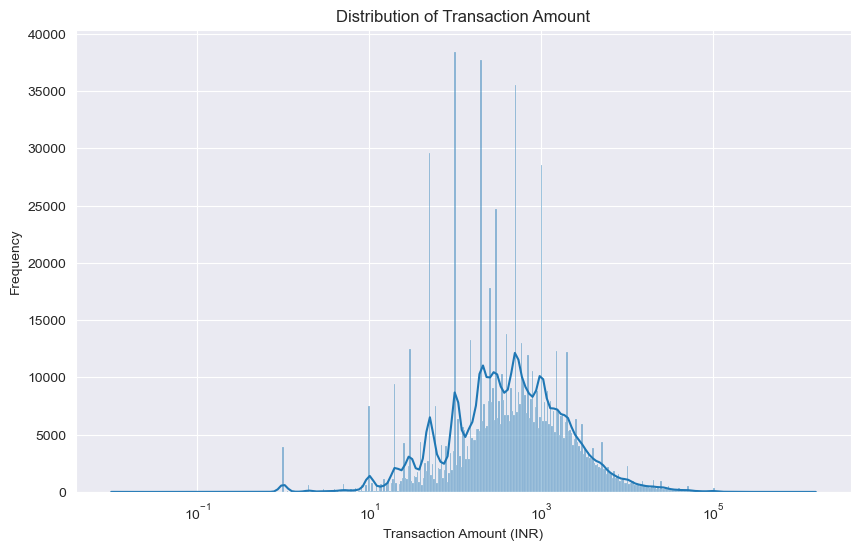

In [21]:
# To Easy to see the distribution, use log scale
# Therefore, use positive TransactionAmount only
positive_transactions = bank_customer[bank_customer['TransactionAmount (INR)'] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(positive_transactions['TransactionAmount (INR)'], kde=True, log_scale=(True, False))
plt.title('Distribution of Transaction Amount')
plt.xlabel('Transaction Amount (INR)')
plt.ylabel('Frequency')
plt.show()

# 2. Distribution of Customer Account Balances

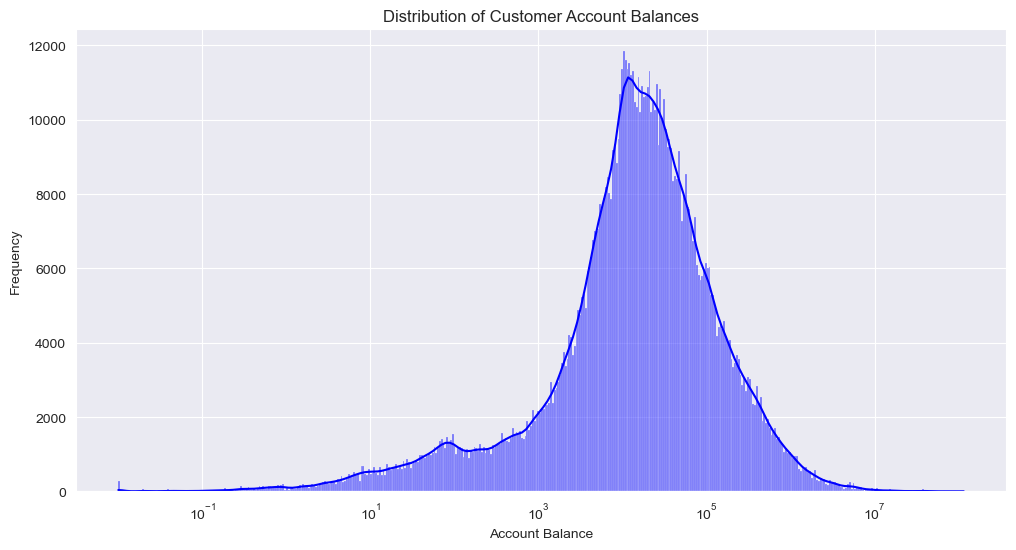

In [46]:
plt.figure(figsize=(12, 6))

positive_CustAccountBalance = bank_customer[bank_customer['CustAccountBalance'] > 0]

# Plotting the distribution of account balances
sns.histplot(positive_CustAccountBalance['CustAccountBalance'], kde=True, color='blue', log_scale=(True, False))
plt.title('Distribution of Customer Account Balances')
plt.xlabel('Account Balance')
plt.ylabel('Frequency')

plt.show()

# 3. Distribution of Customer Gender

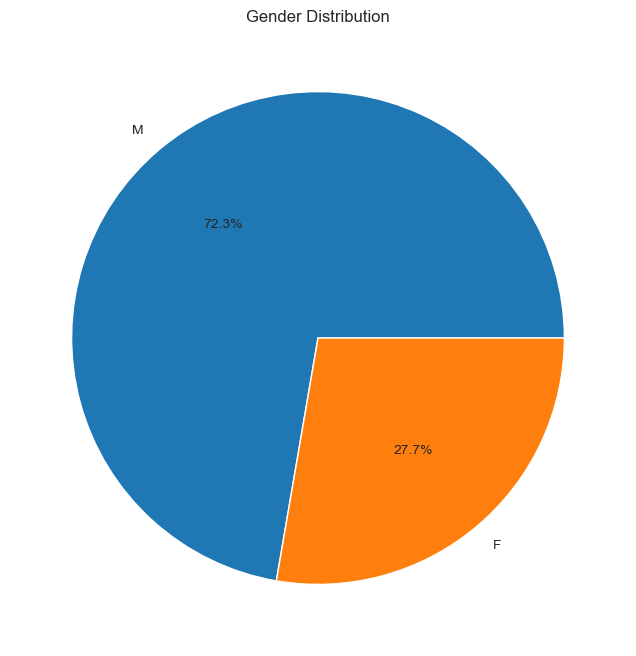

In [51]:
gender_counts = bank_customer['CustGender'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

# 4. Distribution of Customer Age

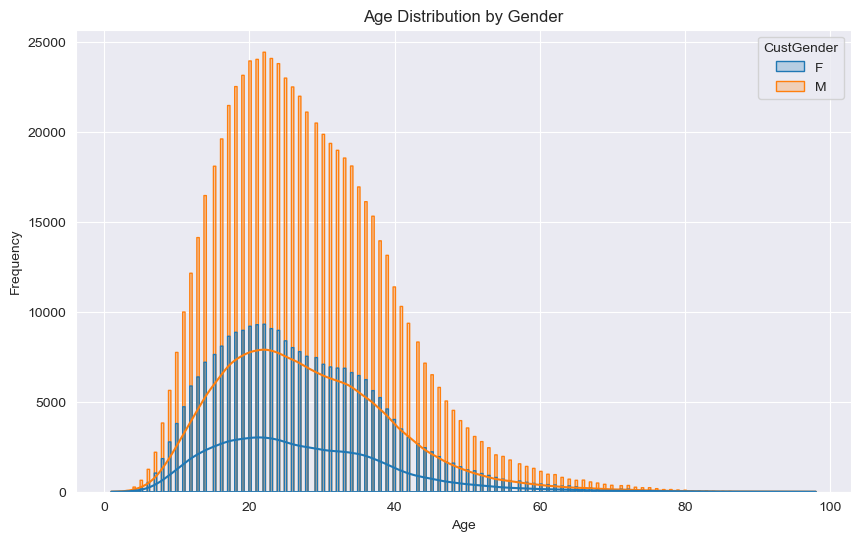

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(bank_customer, x='CustomerAge', hue='CustGender', kde=True, element='step')
plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# 5. Customer Count and Total Account Balance in Top 50 Locations by Customer Count

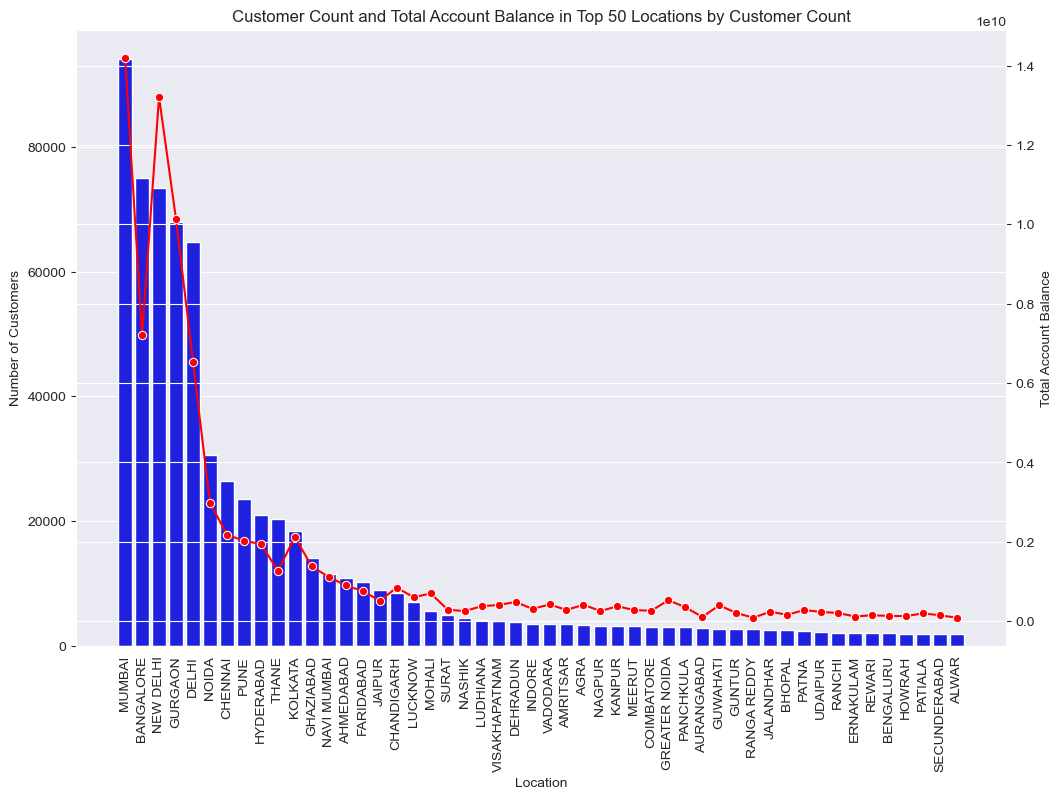

In [24]:
plt.figure(figsize=(12, 8))

# First, find the top 50 locations by number of customers
top_50_locations_by_customers = bank_customer.groupby('CustLocation').size().sort_values(ascending=False).head(50)

# Plot the number of customers using a bar chart
ax = sns.barplot(x=top_50_locations_by_customers.index, y=top_50_locations_by_customers.values, color='blue')
ax.set_ylabel('Number of Customers')
plt.xticks(rotation=90)

# Create a twin axis for the account balance
ax2 = ax.twinx()

# Get the total account balance for the top 50 locations
top_50_balance = bank_customer[bank_customer['CustLocation'].isin(top_50_locations_by_customers.index)].groupby('CustLocation')['CustAccountBalance'].sum()

# Ensure the order of locations matches with the first plot
top_50_balance = top_50_balance.reindex(top_50_locations_by_customers.index)

# Plot the account balance using a line chart
ax2 = sns.lineplot(x=top_50_balance.index, y=top_50_balance.values, marker='o', color='red', ax=ax2)
ax2.set_ylabel('Total Account Balance')

# Set titles and labels
plt.title('Customer Count and Total Account Balance in Top 50 Locations by Customer Count')
ax.set_xlabel('Location')

plt.show()


# 6. Transaction Volume by Hour of Day

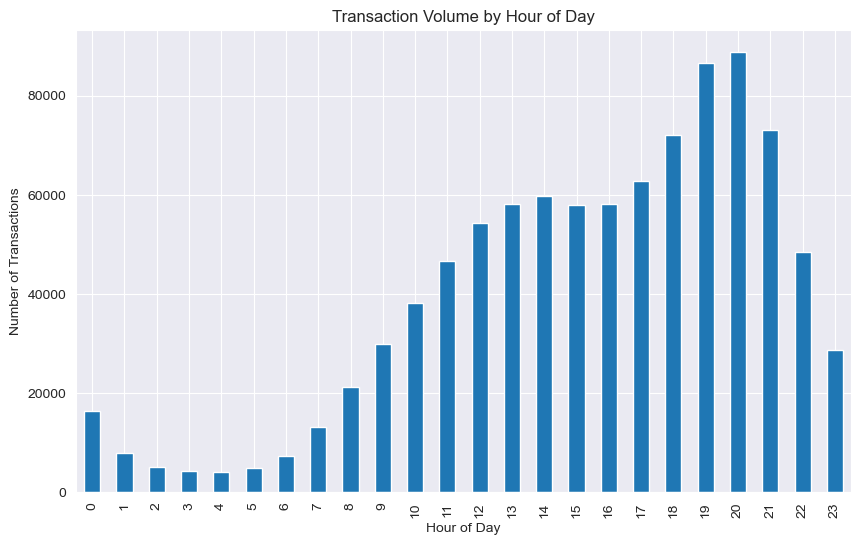

In [28]:
bank_customer['TransactionHour'] = bank_customer['TransactionDateTime'].dt.hour
hourly_transactions = bank_customer.groupby('TransactionHour').size()
hourly_transactions.plot(kind='bar', figsize=(10, 6))
plt.title('Transaction Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(24))
plt.show()


# 7. Relationship Between Transaction Amount and Account Balance by Gender

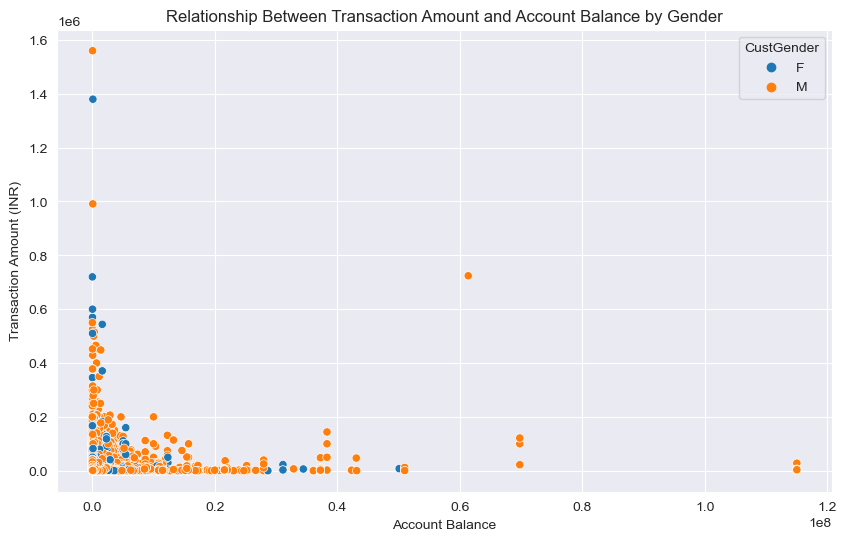

In [59]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CustAccountBalance', y='TransactionAmount (INR)', hue='CustGender', data=bank_customer)
plt.title('Relationship Between Transaction Amount and Account Balance by Gender')
plt.xlabel('Account Balance')
plt.ylabel('Transaction Amount (INR)')
plt.show()

# 8. Relationship Between Transaction Amount and Customer Age by Gender

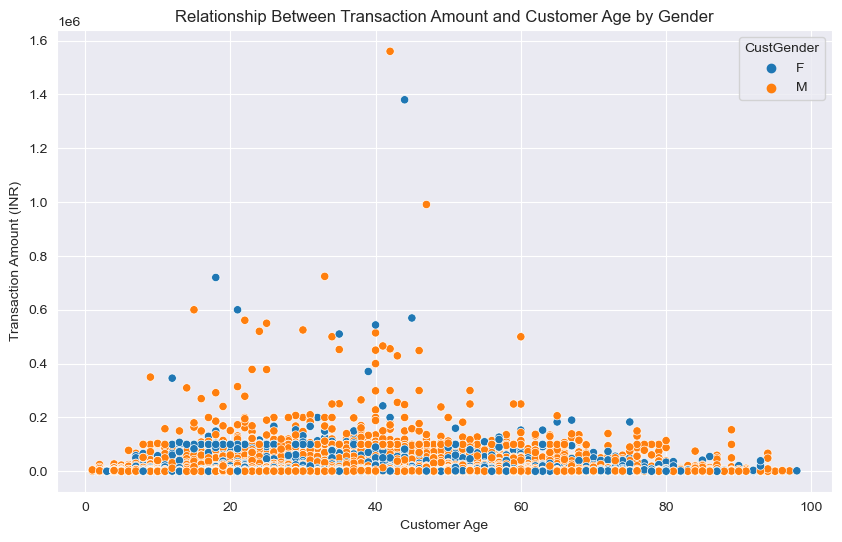

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CustomerAge', y='TransactionAmount (INR)', hue='CustGender', data=bank_customer)
plt.title('Relationship Between Transaction Amount and Customer Age by Gender')
plt.xlabel('Customer Age')
plt.ylabel('Transaction Amount (INR)')
plt.show()

# 9. Relationship Between Account Balance and Customer Age by Gender

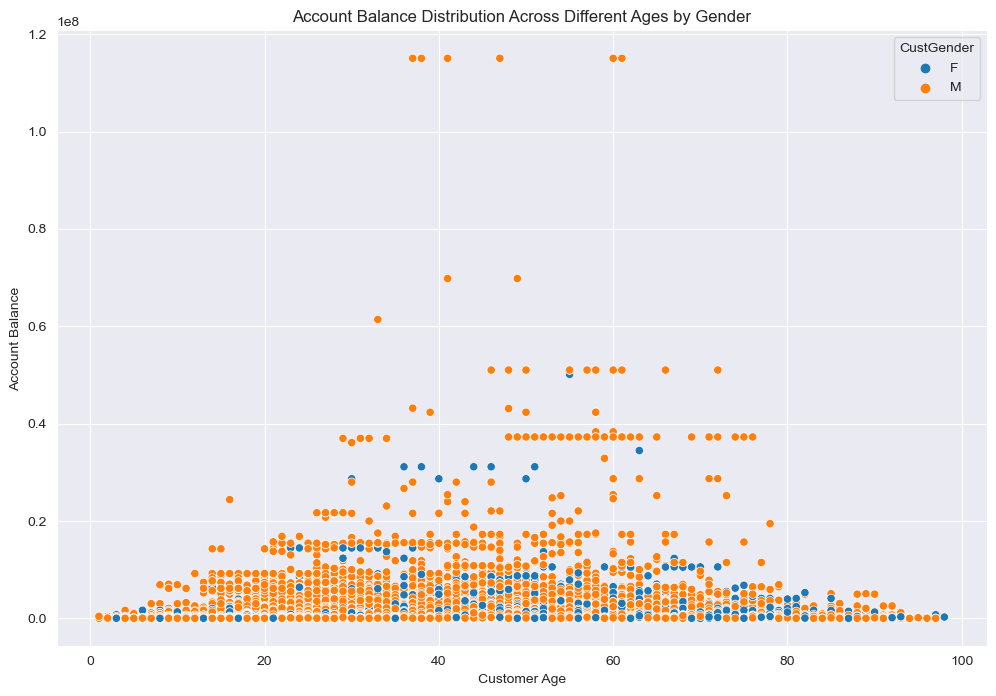

In [58]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='CustomerAge', y='CustAccountBalance', hue='CustGender', data=bank_customer)
plt.title('Account Balance Distribution Across Different Ages by Gender')
plt.xlabel('Customer Age')
plt.ylabel('Account Balance')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Recency distribution
sns.histplot(rfm['Recency'], kde=True)
plt.title('Recency Distribution')
plt.show()



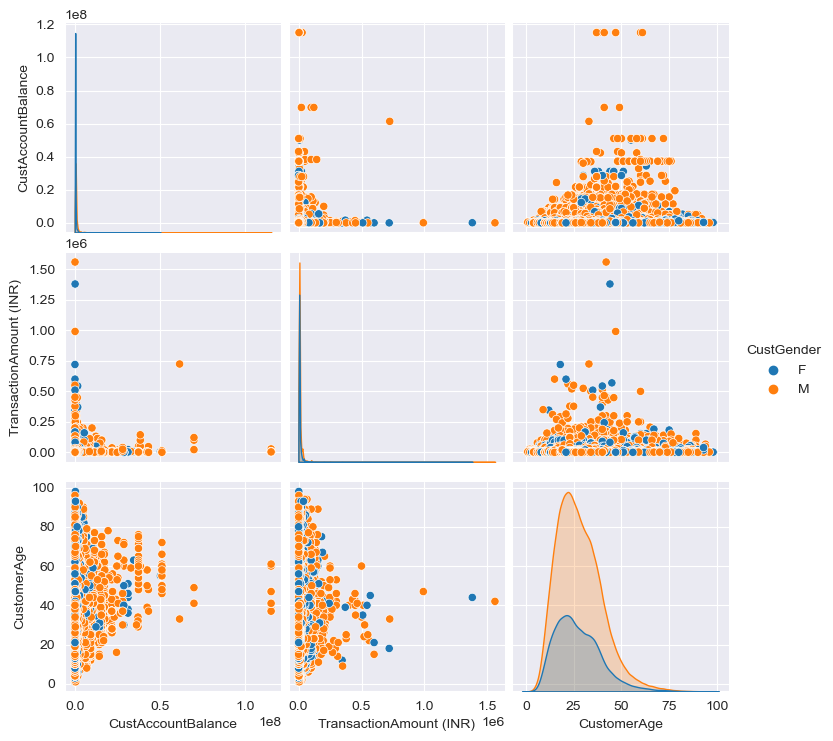

In [30]:
selected_columns = ['CustAccountBalance', 'TransactionAmount (INR)', 'CustomerAge', 'CustGender']

# Creating the pair plot with gender as the hue
sns.pairplot(bank_customer[selected_columns], hue='CustGender')
plt.show()

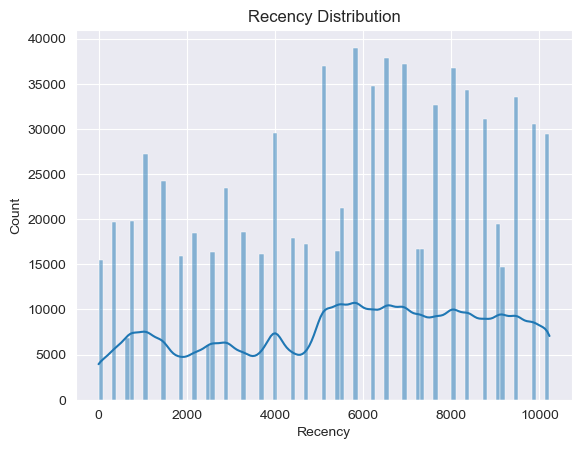

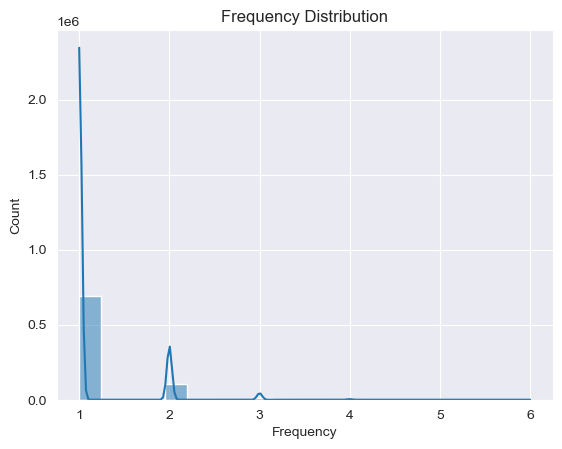

In [35]:
# Frequency distribution
sns.histplot(rfm['Frequency'], kde=True)
plt.title('Frequency Distribution')
plt.show()

Number of customers with zero monetary value: 505


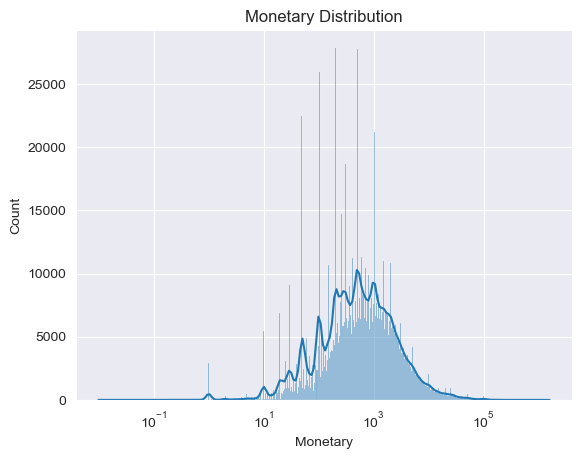

In [44]:
positive_rfm_monetary = rfm[rfm['Monetary'] > 0]
print("Number of customers with zero monetary value:", (rfm['Monetary'] == 0).sum())

# Monetary distribution
sns.histplot(positive_rfm_monetary['Monetary'], kde=True, log_scale=(True, False))
plt.title('Monetary Distribution')
plt.show()